In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm

In [2]:
pi = 0.5 #bernoulli sampling probability
n = 3 #sample size
N = 5 #population size
sim = 1000 #simulation times

#bernoulli sampling
np.random.seed(0)
record_bernoulli = np.zeros([sim, N]) #set zero array
for i in range(sim):
    for j in range(N):
        random_number = np.random.random() # Choose random number between zero and one
        if random_number < pi:
            record_bernoulli[i,j]+=1 #record sampling result
            
pi_hat_bernoulli = record_bernoulli.mean(axis=0) #column mean for number of each index
print(pi_hat_bernoulli)

pi_2_hat_bernoulli = np.zeros([1,N])
for j in range(N):
    #record the trials where index 1 and index i are seleced 
    index_bernoulli = np.where((record_bernoulli[:,0] ==1) & (record_bernoulli[:,j] ==1))[0]
    num = len(index_bernoulli)
    pi_2_hat_bernoulli[:,j] = num / sim
print(pi_2_hat_bernoulli)

[0.514 0.509 0.531 0.503 0.484]
[[0.514 0.257 0.272 0.261 0.235]]


In [3]:
#simple random sampling
np.random.seed(1)
record_srs = np.zeros([sim, n])
for i in range(sim):
    record_srs[i,:] = np.random.choice(N, n, replace = False) #simple random sampling (N,n)
pi_hat_srs = np.zeros([1,5])
for j in range(N):
    index_srs = np.where(record_srs == j)[0] #record the trials which index i is selected
    pi_hat_srs[:,j] = len(index_srs) / sim #calculate the probability
print(pi_hat_srs)

pi_2_hat_srs = np.zeros([1, N])
num_2_hat_srs = np.zeros([1,N])
record_srs_0 = record_srs[np.where(record_srs == 0)[0],:] #the trials which index 1 is selected
for j in range(N):
    for i in range(len(record_srs_0)):
         if j in record_srs_0[i,:]:
            num_2_hat_srs[0, j]+=1 #calculate the number of trials which index 1 and the index j are selected at the same time
pi_2_hat_srs = num_2_hat_srs / sim
print(pi_2_hat_srs)

[[0.599 0.612 0.591 0.586 0.612]]
[[0.599 0.313 0.29  0.297 0.298]]


In [4]:
np.random.seed(2)
N_female = 4000
N_male = 1000
N = 5000
y_female = np.random.normal(loc = 95.0, scale = 2, size = N_female)
y_male = np.random.normal(loc = 130.0, scale = 2, size = N_male)
y = np.hstack((y_female, y_male)) #combine two population

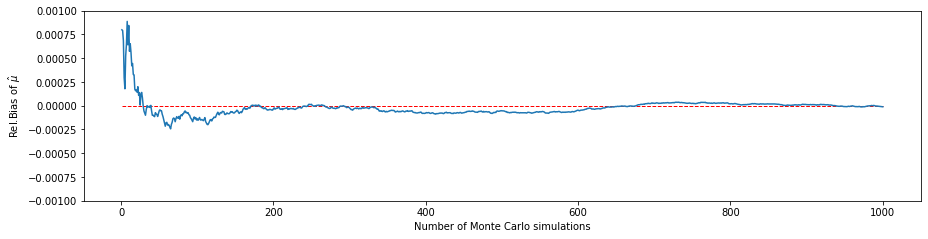

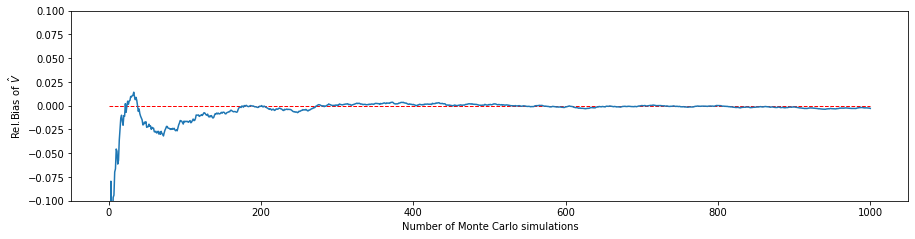

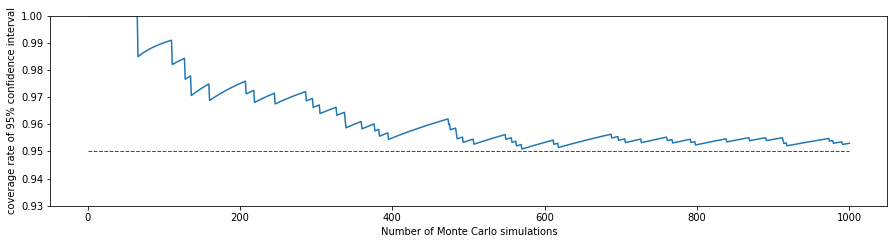

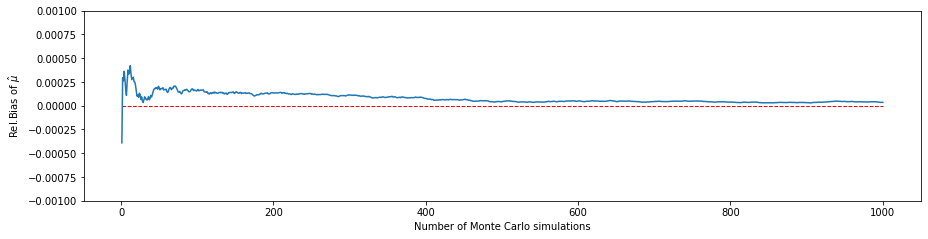

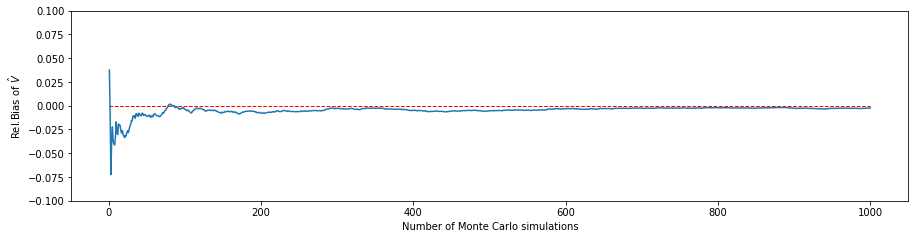

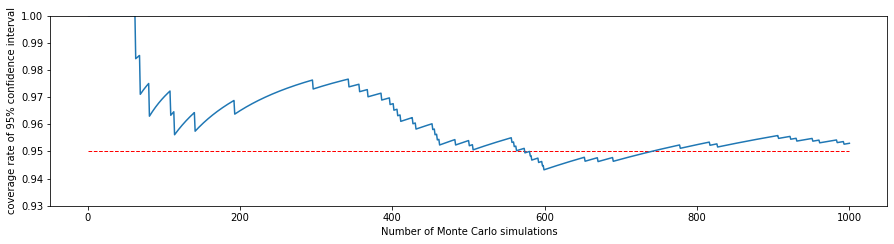

In [5]:
#population 
mu = sum(y)/N
s2_female_pop = np.var(y_female, ddof = 1) #female S^2 of population
s2_male_pop = np.var(y_male, ddof = 1) #male S^2 of population

np.random.seed(3)
def srs(n):
    sample_index_female = np.random.choice(N_female, n, replace = False)
    sample_index_male = np.random.choice(N_male, n, replace = False)
    #sample estimations
    mu_female = np.mean(y_female[sample_index_female])
    mu_male = np.mean(y_male[sample_index_male])
    mu_hat = 0.8 * np.mean(y_female[sample_index_female]) + 0.2 * np.mean(y_male[sample_index_male])
    s2_female = np.var(y_female[sample_index_female], ddof = 1) #female variance estimator
    s2_male = np.var(y_male[sample_index_male], ddof = 1) #male variance estimator
    var_est_hat = 0.8 ** 2 /n * (1 - n / N_female) * s2_female + 0.2 ** 2 /n * (1 - n / N_male) * s2_male #variance estimator
    return mu_hat, var_est_hat

cum_size = [k+1 for k in range(1000)]
q_upper = norm.ppf(0.975)
q_lower = norm.ppf(0.025)

results_srs = {}
for n in [100, 300]:
    var_est = 0.8 ** 2 / n * (1 - n / N_female) * s2_female_pop + 0.2 ** 2 / n * (1 - n / N_male) * s2_male_pop #variance
    results_srs[n] = np.zeros([1000, 2])
    for i in range(1000):
        results_srs[n][i, :] = srs(n)

    #relative Monte Carlo bias of mu_hat  
    cum_mu_hat = np.cumsum(results_srs[n][:,0]) / cum_size
    RB_mu_hat = (cum_mu_hat - mu) / mu
    fig = plt.figure(figsize = (15, 3.5))
    plt.plot(cum_size, RB_mu_hat)
    plt.hlines(0, 1, 1000, color = 'r', linestyle = 'dashed', linewidth = 1)
    plt.xlabel('Number of Monte Carlo simulations')
    plt.ylabel(r'Rel.Bias of $\hat{\mu}$')
    plt.ylim(-0.001, 0.001)
    plt.savefig('Relative_MCB_mu_hat_'+str(n)+'.png')
    plt.show()
    plt.close()

    #relative Monte Carlo bias of var_hat 
    cum_var_est_hat = np.cumsum(results_srs[n][:,1]) / cum_size
    RB_var_hat = (cum_var_est_hat - var_est) / var_est
    fig = plt.figure(figsize = (15, 3.5))
    plt.plot(cum_size, RB_var_hat)
    plt.hlines(0, 1, 1000, color = 'r', linestyle = 'dashed', linewidth = 1)
    plt.xlabel('Number of Monte Carlo simulations')
    plt.ylabel(r'Rel.Bias of $\hat{V}$')
    plt.ylim(-0.1, 0.1)
    plt.savefig('Relative_MCB_V_hat_'+str(n)+'.png')
    plt.show()
    plt.close()

    #relative Monte Carlo coverage rate
    test_result = np.zeros(1000)
    for i in range(1000):
        test_result[i] = (results_srs[n][i,0] + q_lower * np.sqrt(results_srs[n][i,1]) < mu) and \
        (results_srs[n][i,0] + q_upper * np.sqrt(results_srs[n][i,1]) > mu)
    cum_coverage_rate = np.cumsum(test_result) / cum_size
    fig = plt.figure(figsize = (15, 3.5))
    plt.plot(cum_size, cum_coverage_rate)
    plt.hlines(0.95, 1, 1000, color = 'r', linestyle = 'dashed', linewidth = 1)
    plt.xlabel('Number of Monte Carlo simulations')
    plt.ylabel('coverage rate of 95% confidence interval')
    plt.ylim(0.93, 1)
    plt.savefig('Coverage_ra te_'+str(n)+'.png')
    plt.show()
    plt.close()